In [1]:
import sys
import os
import pandas
import numpy as np 
import io 
from rdkit import Chem
sys.path.append("../")
import mol_cv
import load_medchem_data
import predict_medchem
from cv_plot import cv_plot_fig
import PIL

In [2]:
predictor_dict = predict_medchem.all_predictors()

In [3]:
fda = load_medchem_data.load_fda_drugs()
rows = mol_cv.calculate_properties(fda["mol"],predictor_dict)
fda["cluster"] = predict_medchem.cluster(mols=fda["mol"],fingerprint_size=1024,cutoff=0.5)

Getting distances: 100%|█████████████████████████████████████████████████████████████████| 1613/1613 [00:00<00:00, 4136.07it/s]


In [4]:
from rdkit.Chem.rdMolAlign import AlignMol
from rdkit.Chem import rdFMCS, AllChem, MolToSmiles, rdDepictor
from rdkit.Chem.Draw.rdMolDraw2D import PrepareMolForDrawing
from rdkit.Geometry.rdGeometry import Point2D

def align_cluster(cluster_1):
    mols = list(cluster_1["mol"])
    # see https://github.com/rdkit/rdkit/discussions/4120
    mcs = rdFMCS.FindMCS(mols)
    template = Chem.MolFromSmarts(mcs.smartsString)
    AllChem.Compute2DCoords(template) #coordMap={0:Point2D(0,0])})
    PrepareMolForDrawing(template)
    for m in mols:
        AllChem.GenerateDepictionMatching2DStructure(m , template)
    highlight_substructure = []
    for m in mols:
        match1 = m.GetSubstructMatch(template)
        target_atm1 = []
        for atom in m.GetAtoms():
            if atom.GetIdx() not in match1:
                target_atm1.append(atom.GetIdx())
        highlight_substructure.append(target_atm1)
    return highlight_substructure


In [5]:
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import MolsToGridImage
from collections import Counter
counter = Counter(fda["cluster"])
fda["cluster_size"] = fda["cluster"].map(counter)
cluster_1 = fda[fda["cluster"] == 2]
highlight_substructure = align_cluster(cluster_1)
# see https://www.rdkit.org/docs/source/rdkit.Chem.Draw.rdMolDraw2D.html#rdkit.Chem.Draw.rdMolDraw2D.MolDrawOptions
dopts = rdMolDraw2D.MolDrawOptions()
dopts.drawMolsSameScale = True
#dopts.fixedScale = 0.06
dopts.centreMoleculesBeforeDrawing = False
dopts.bgColor = None
factor = 3
image_height = 120 * factor
image_width= 300 * factor
mols = list(cluster_1["mol"])
png_grid = MolsToGridImage(mols,drawOptions=dopts,molsPerRow=1,
                           subImgSize=(image_width, image_height),returnPNG=False,
                           highlightAtomLists=highlight_substructure)
def white_to_transparency(img):
    x = np.asarray(img.convert('RGBA')).copy()
    x[:, :, 3] = (255 * (x[:, :, :3] != 255).any(axis=2)).astype(np.uint8)
    return x

png_array = white_to_transparency(png_grid)
individual_images = [png_array[i*image_height:(i+1)*image_height,:,:]
                     for i in range(len(mols))]

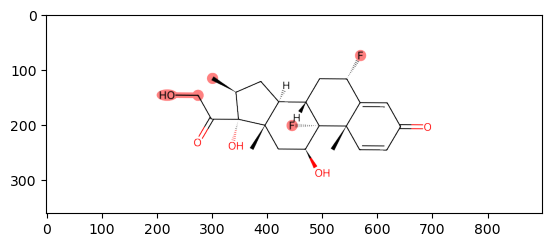

In [6]:
from matplotlib import pyplot as plt
plt.imshow(individual_images[0])

In [7]:
%%capture
# previous line prevents output from displaying in cell
images = []
for row,image in zip(rows,individual_images):
    fig = cv_plot_fig(row,image_mol=image,turn_imshow_axis_off=True,w_pad=-5)
    buf = io.BytesIO()
    fig.savefig(buf,bbox_inches='tight')
    buf.seek(0)
    images.append(PIL.Image.open(buf))
images[0].save('animated_plot.gif', save_all=True, append_images=images, duration=500, loop=0)

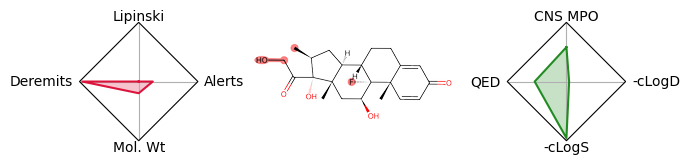

In [8]:
fig